In [86]:
import librosa
import os
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct
from librosa.feature import mfcc
from IPython.display import Audio,display
import pandas as pd
import time
import soundfile as sf
import random
plt.ion()
from librosa.feature import delta

In [87]:
audiopath=r"C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac"

In [89]:
def process_audio_file(file_path, target_sr=8000, silence_threshold=20):
    signal, original_sr = librosa.load(file_path, sr=None)
    
    # Downsample the audio to reduce the size
    signal_resampled = librosa.resample(signal, orig_sr=original_sr, target_sr=target_sr)
    
    # Trim silence
    trimmed_signal, _ = librosa.effects.trim(signal_resampled, top_db=silence_threshold)
    
    output_file = file_path.replace('.flac', f'_processed_{target_sr}.flac')
    sf.write(output_file, trimmed_signal, target_sr)
    
    return output_file


def process_dataset(audiopath, target_sr=8000, num_samples=5000):
    all_files = [os.path.join(audiopath, f) for f in os.listdir(audiopath) if f.endswith('.flac')]
    
    if len(all_files) < num_samples:
        print(f"Only {len(all_files)} files available. Processing all of them.")
        num_samples = len(all_files)
    
    selected_files = random.sample(all_files, num_samples)
    
    processed_files = []
    for file in selected_files:
        processed_file = process_audio_file(file, target_sr=target_sr)
        processed_files.append(processed_file)
        print(f"Processed and saved: {processed_file}")

    return processed_files

processed_files = process_dataset(audiopath, target_sr=8000, num_samples=5000)




Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_8545794_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_3369186_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_2362998_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_3866909_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_1645239_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_5320075_processed_8000_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_6364911_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_4920471_processed_8000_processed_8000.flac
Processed and save

Playing: LA_E_8545794_processed_8000.flac


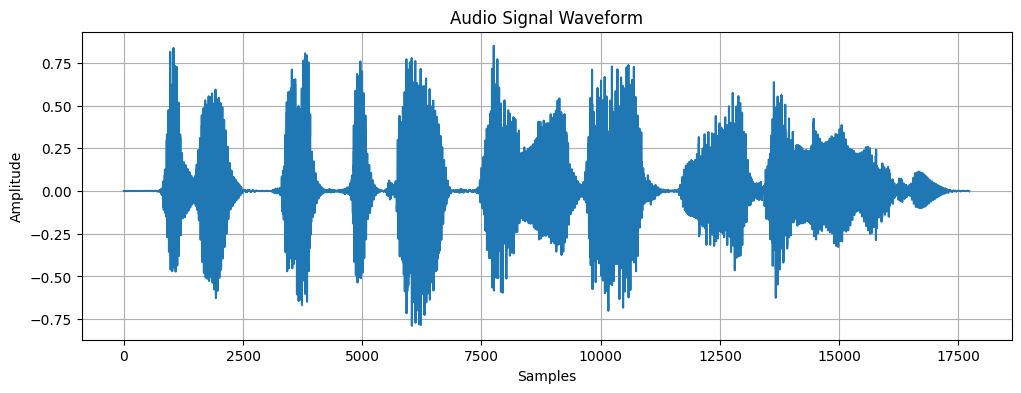

Playing: LA_E_3369186_processed_8000.flac


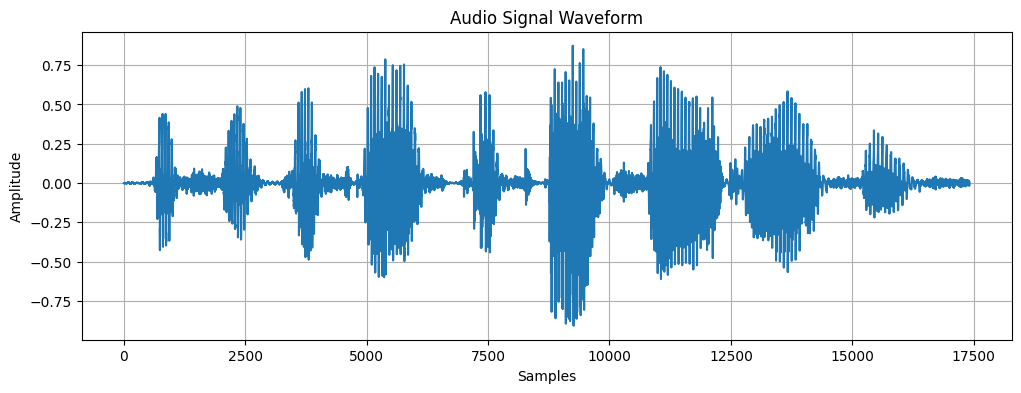

Playing: LA_E_2362998_processed_8000.flac


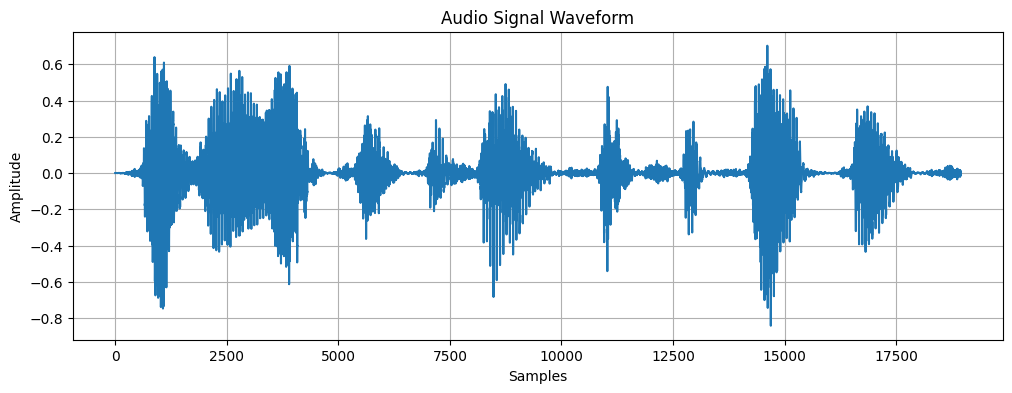

Finished playing selected audio files.


In [90]:
def plot_audio_waveform(signal, sr):
    """Plots the waveform of the audio signal."""
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title('Audio Signal Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

def load_and_play_audio(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    
    print(f"Playing: {os.path.basename(file_path)}")
    plot_audio_waveform(signal, sr)
    display(Audio(data=signal, rate=sr))  
    time.sleep(3)

files_to_play = processed_files[:3] 

for file_path in files_to_play:
    load_and_play_audio(file_path)

print("Finished playing selected audio files.")





In [130]:
def read_csv_file(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    if os.path.getsize(file_path) == 0:
        print(f"File is empty: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path)
        print(f"Read {len(df)} rows from {file_path}")
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def save_csv_file(data, file_path):
    if data is None or len(data) == 0:
        print("No data to save.")
        return

    try:
        data.to_csv(file_path, index=False)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving file: {e}")

def spectral_subtraction(signal, noise_estimation_factor=0.1):
    stft = librosa.stft(signal)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_magnitude = np.mean(magnitude, axis=1, keepdims=True) * noise_estimation_factor
    magnitude_clean = np.maximum(magnitude - noise_magnitude, 1e-6)  # Avoid zeros
    cleaned_stft = magnitude_clean * np.exp(1j * phase)
    cleaned_signal = librosa.istft(cleaned_stft)
    return cleaned_signal

def pre_emphasis(signal, alpha=0.97):
    emphasized_signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    return emphasized_signal if np.any(emphasized_signal) else np.array([])  

def preprocess_audio(file_path, sr=None):
    signal, sr = librosa.load(file_path, sr=sr)

    signal = signal / (np.max(np.abs(signal)) + np.finfo(float).eps)

    signal = pre_emphasis(signal)
    
    signal, _ = librosa.effects.trim(signal)

    cleaned_signal = spectral_subtraction(signal)

    print(f"Sample Rate: {sr} Hz")
    print(f"Processed Signal Length: {len(cleaned_signal)} samples")
    print(f"Processed Signal (first 10 samples): {cleaned_signal[:10]}")

    if len(cleaned_signal) == 0:
        print(f"No audio data to save for {file_path}. Skipping...")
        return None, None, None

    cleaned_file_path = file_path.replace('.flac', '_cleaned.wav')

    try:
        sf.write(cleaned_file_path, cleaned_signal, sr)
        print(f"Cleaned signal saved to {cleaned_file_path}.")
    except Exception as e:
        print(f"Error saving file: {e}")
        return None, None, None

    plt.figure(figsize=(12, 4))
    plt.plot(cleaned_signal)
    plt.title(f"Cleaned Audio Signal: {os.path.basename(file_path)}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    
    return cleaned_signal, sr, cleaned_file_path

def preprocess_audio_directory(path):
    processed_signals = []
    sample_rates = []
    files_processed = []

    for filename in os.listdir(path):
        if filename.endswith('.wav') or filename.endswith('.flac'):  # Include multiple formats
            file_path = os.path.join(path, filename)
            print(f"Processing {file_path}...")
            processed_signal, sample_rate, cleaned_file_path = preprocess_audio(file_path)
            
            if processed_signal is not None:
                processed_signals.append(processed_signal)
                sample_rates.append(sample_rate)
                files_processed.append(cleaned_file_path)

    return processed_signals, sample_rates, files_processed

Processed sample 1/5: MFCCs shape (79, 20)
Processed sample 2/5: MFCCs shape (79, 20)
Processed sample 3/5: MFCCs shape (79, 20)
Processed sample 4/5: MFCCs shape (79, 20)
Processed sample 5/5: MFCCs shape (79, 20)
Sample 1 - MFCCs shape: (79, 20)
Sample 1 - Delta shape: (79, 20)
Sample 1 - Double Delta shape: (79, 20)
Sample 2 - MFCCs shape: (79, 20)
Sample 2 - Delta shape: (79, 20)
Sample 2 - Double Delta shape: (79, 20)
Sample 3 - MFCCs shape: (79, 20)
Sample 3 - Delta shape: (79, 20)
Sample 3 - Double Delta shape: (79, 20)
Sample 4 - MFCCs shape: (79, 20)
Sample 4 - Delta shape: (79, 20)
Sample 4 - Double Delta shape: (79, 20)
Sample 5 - MFCCs shape: (79, 20)
Sample 5 - Delta shape: (79, 20)
Sample 5 - Double Delta shape: (79, 20)


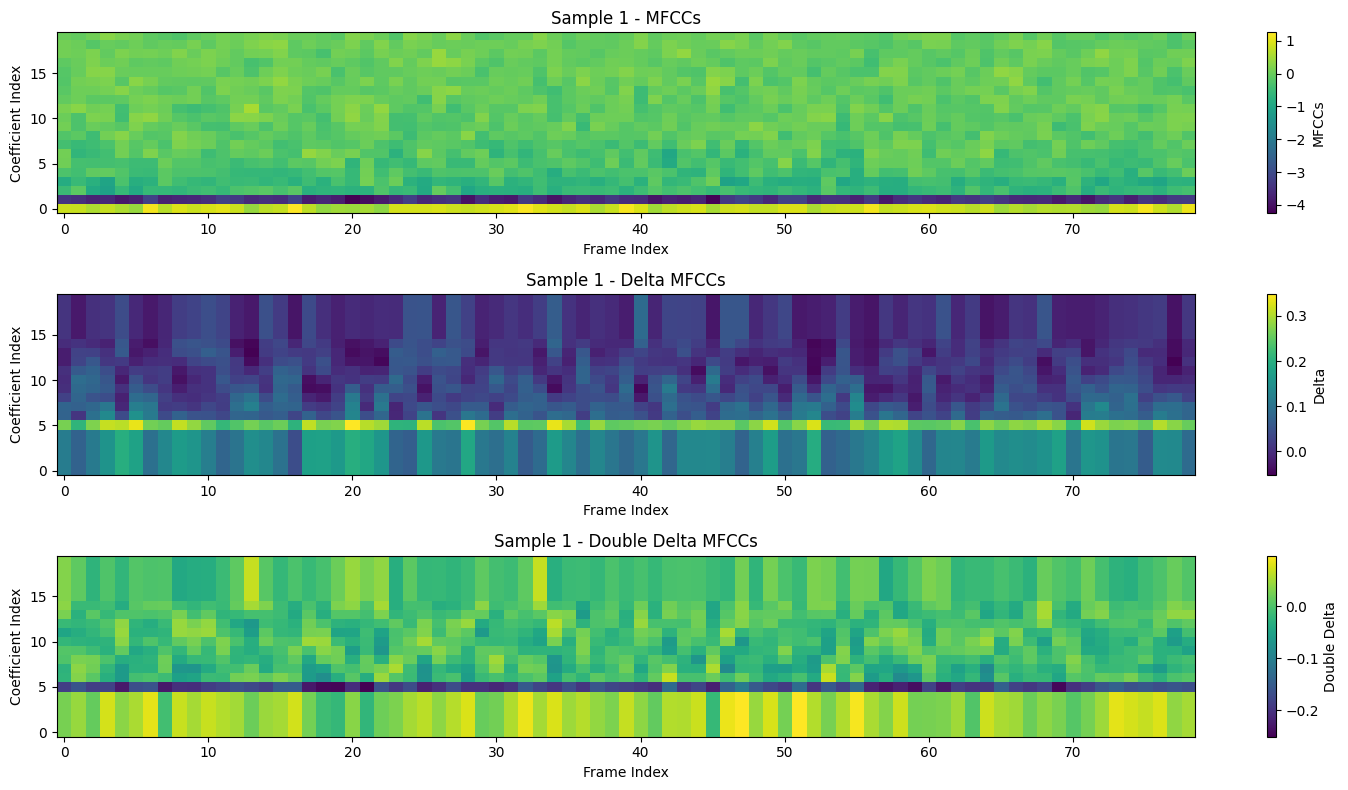

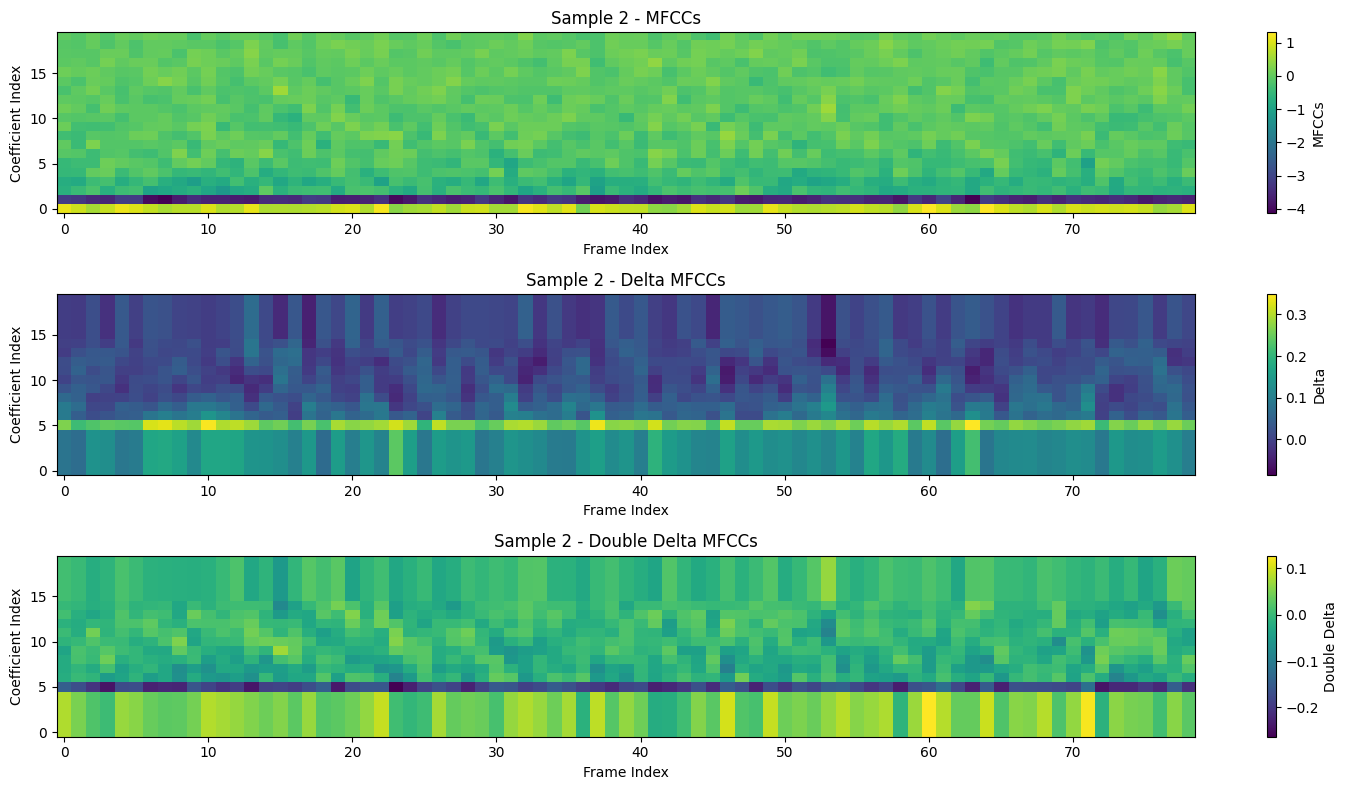

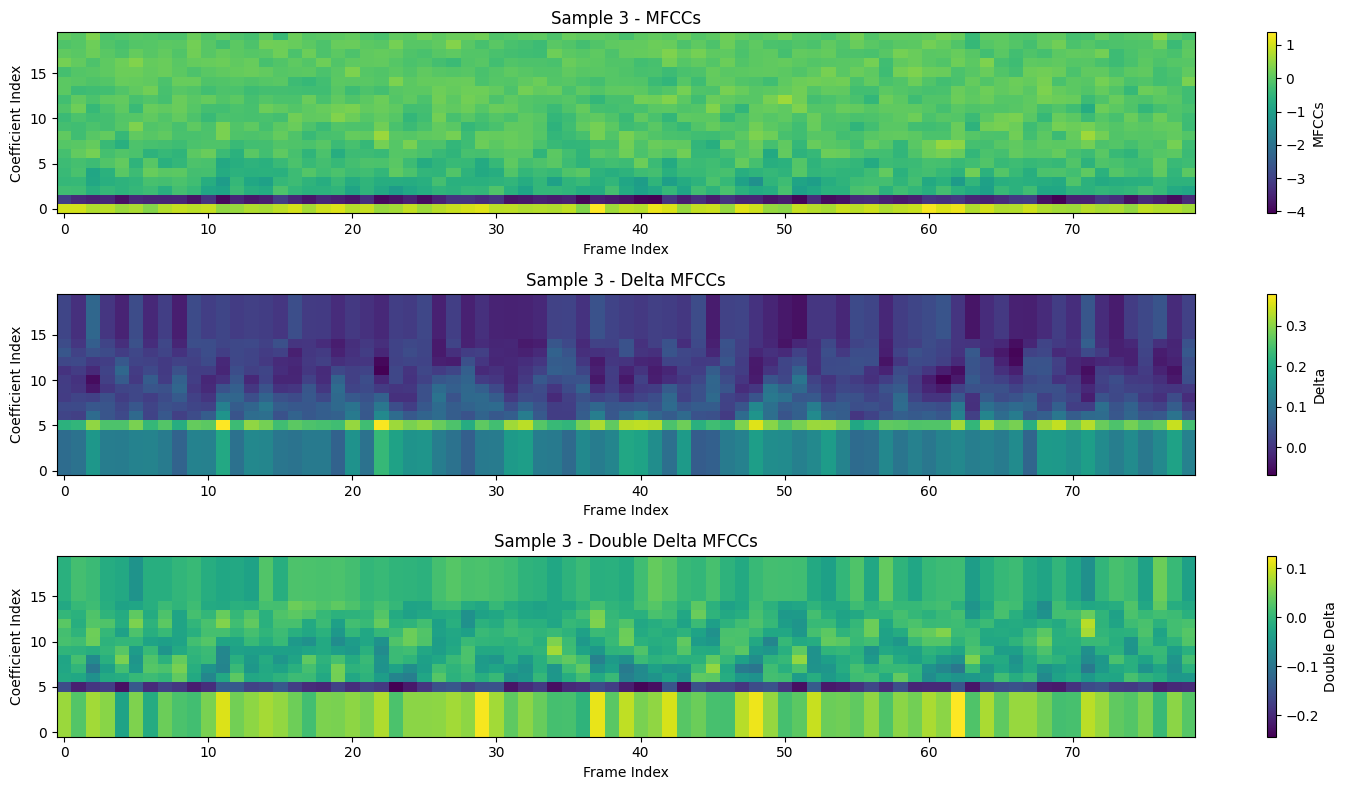

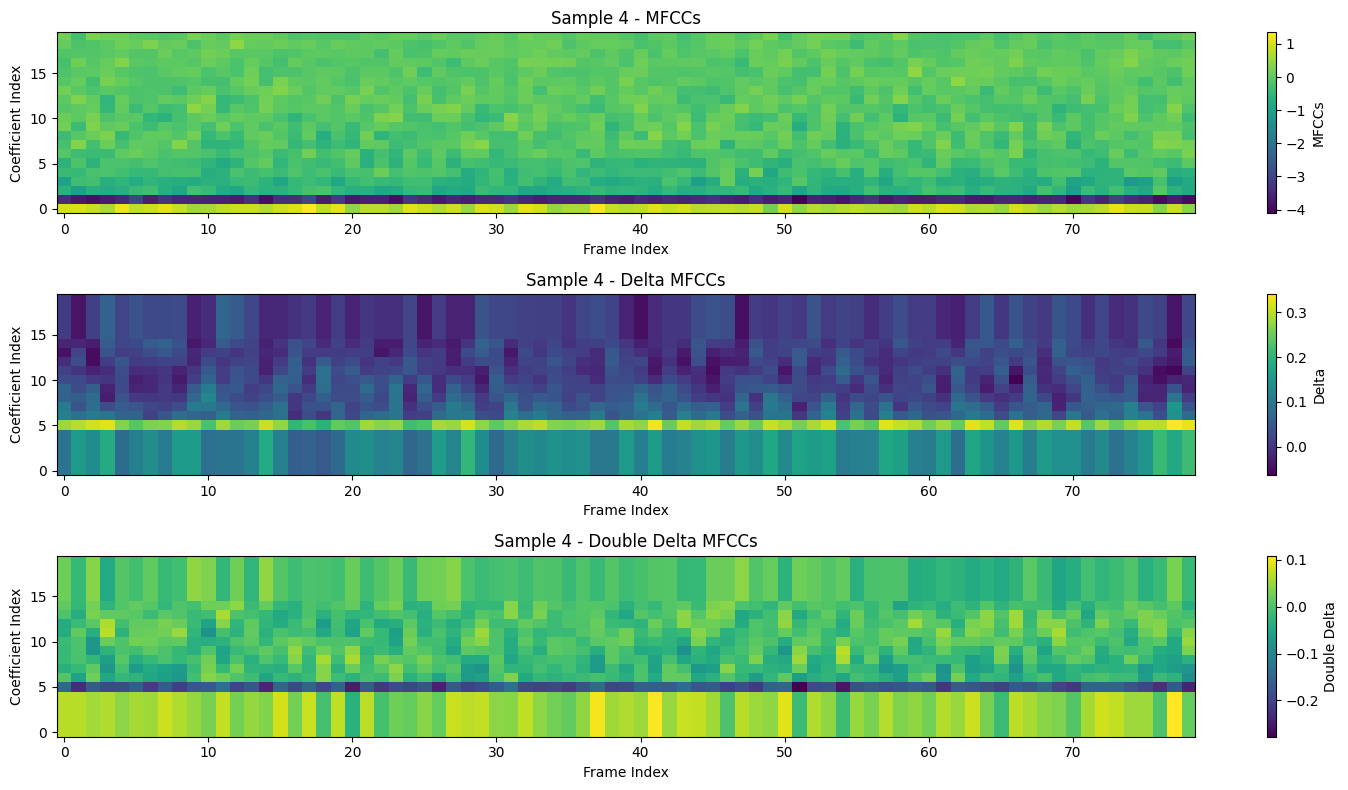

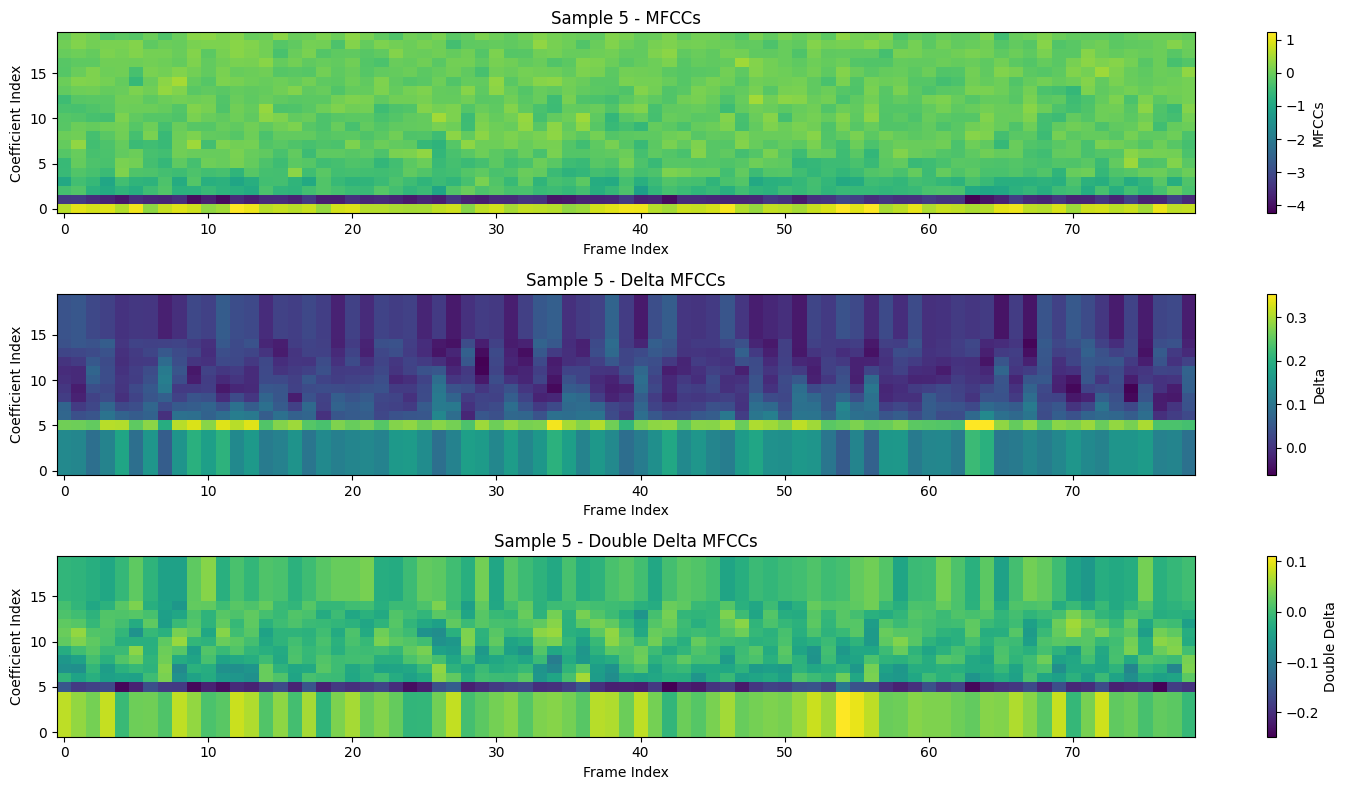

In [131]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):

    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])

    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2  # Overlap of 50%
    
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T

    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w

    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    fr_all = fr_all[:, :NFFT // 2 + 1]  
    
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    mel_spectrum = np.dot(fr_all, mel_filters.T)
    
    log_mel_spectrum = np.log10(np.maximum(mel_spectrum, np.finfo(float).eps))  
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    delta = librosa.feature.delta(mfccs)
    double_delta = librosa.feature.delta(mfccs, order=2)
    
    # Ensure MFCCs are not zeros
    if np.any(mfccs):
        return mfccs, delta, double_delta
    else:
        return None, None, None

def extract_mfcc_multiple(samples, Fs, Window_Length, NFFT, No_Filter):
    all_mfccs, all_delta, all_double_delta = [], [], []
    
    for idx, speech in enumerate(samples):
        if np.count_nonzero(speech) == 0:
            print(f"Warning: Sample {idx} contains only zeros.")
            continue

        mfccs, delta, double_delta = extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter)
        
        # Check and store if valid MFCCs are extracted
        if mfccs is not None:
            all_mfccs.append(mfccs)
            all_delta.append(delta)
            all_double_delta.append(double_delta)
            print(f'Processed sample {idx + 1}/{len(samples)}: MFCCs shape {mfccs.shape}')
        else:
            print(f"Warning: Sample {idx} has invalid MFCCs.")
    
    with open('mfcc_features.csv', 'w') as f:
        for mfcc in all_mfccs:
            np.savetxt(f, mfcc, delimiter=",")
    
    return all_mfccs, all_delta, all_double_delta

sr = 16000 
num_samples = 5
samples = [np.random.randn(sr) for _ in range(num_samples)]  

Window_Length = 25  
NFFT = 512 
No_Filter = 20 

all_mfccs, all_delta, all_double_delta = extract_mfcc_multiple(samples, sr, Window_Length, NFFT, No_Filter)

for i in range(num_samples):
    print(f'Sample {i + 1} - MFCCs shape: {all_mfccs[i].shape}')
    print(f'Sample {i + 1} - Delta shape: {all_delta[i].shape}')
    print(f'Sample {i + 1} - Double Delta shape: {all_double_delta[i].shape}')

def plot_features_multiple(all_mfccs, all_delta, all_double_delta):
    num_samples = len(all_mfccs)
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 8))

        plt.subplot(3, 1, 1)
        plt.imshow(all_mfccs[i].T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='MFCCs')
        plt.title(f'Sample {i + 1} - MFCCs')
        plt.xlabel('Frame Index')
        plt.ylabel('Coefficient Index')

        plt.subplot(3, 1, 2)
        plt.imshow(all_delta[i].T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Delta')
        plt.title(f'Sample {i + 1} - Delta MFCCs')
        plt.xlabel('Frame Index')
        plt.ylabel('Coefficient Index')

        plt.subplot(3, 1, 3)
        plt.imshow(all_double_delta[i].T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Double Delta')
        plt.title(f'Sample {i + 1} - Double Delta MFCCs')
        plt.xlabel('Frame Index')
        plt.ylabel('Coefficient Index')

        plt.tight_layout()
        plt.show()

plot_features_multiple(all_mfccs, all_delta, all_double_delta)

In [124]:
def trim_speech(speech, threshold):
    # Find non-silent indices
    non_silent_indices = np.where(np.abs(speech) > threshold)[0]

    if non_silent_indices.size == 0:
        return speech

    start = non_silent_indices[0]
    end = non_silent_indices[-1] + 1  

    return speech[start:end]

def trimf(x, params):
    if len(params) != 3:
        raise ValueError("trimf requires params to be a list of 3 elements")

    a, b, c = params

    if not all(isinstance(param, (int, float)) for param in params):
        raise TypeError("All parameters must be numeric")
    
    y = np.zeros_like(x)
    
    if a < b < c:
        index_1 = (x > a) & (x < b)
        y[index_1] = (x[index_1] - a) / (b - a)

        index_2 = (x > b) & (x < c)
        y[index_2] = (c - x[index_2]) / (c - b)
        
        y[x == b] = 1.0
    else:
        raise ValueError("Parameters must satisfy a < b < c")

    return y

In [126]:
def delta(features, N=2):
    num_features, num_coeffs = features.shape
    deltas = np.zeros(features.shape)

    for t in range(num_features):
        delta_sum = 0
        for n in range(-N, N + 1):
            if 0 <= t + n < num_features:
                delta_sum += n * features[t + n]
        # Avoid dividing by zero
        if np.sum(np.arange(1, N + 1)) != 0:
            deltas[t] = delta_sum / (2 * N * np.sum(np.arange(1, N + 1)))
        else:
            deltas[t] = 0

    return deltas

In [127]:
def extract_lfcc(samples, Fs, Window_Length, NFFT, No_Filter):
    """Extracts LFCCs, delta, and double delta from multiple speech signals."""
    
    all_stat = []
    all_delta = []
    all_double_delta = []

    for idx, speech in enumerate(samples):
        # Pre-emphasis
        speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
        
        frame_length_in_samples = int((Fs / 1000) * Window_Length)
        hop_length = frame_length_in_samples // 2
        framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
        w = np.hamming(frame_length_in_samples)
        y_framed = framedspeech * w
        
        f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
        filter_bandwidths = np.linspace(min(f), max(f), No_Filter + 2)
        
        fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
        fa_all = fr_all[:, :NFFT // 2 + 1]
        
        f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
        filter_bandwidths = np.linspace(min(f), max(f), No_Filter + 2)
        filterbank = np.zeros((NFFT // 2 + 1, No_Filter))
        for i in range(No_Filter):
            filterbank[:, i] = np.maximum(0, 1 - np.abs((f - filter_bandwidths[i]) / (filter_bandwidths[i + 1] - filter_bandwidths[i])))

        filbanksum = np.dot(fa_all, filterbank)

        if np.all(filbanksum == 0):
            print(f"Warning: Sample {idx} has all-zero filter bank sum.")
            continue 

        t = dct(np.log10(filbanksum + np.finfo(float).eps), type=2, axis=1, norm='ortho')[:, :No_Filter]

        stat=t.T

        if stat.shape[0] >= 3:
            width = min(9, stat.shape[0])  # Width must not exceed the number of frames
            delta = librosa.feature.delta(stat, width=width, mode='constant').T
            double_delta = librosa.feature.delta(stat, order=2, width=width, mode='constant').T
        else:
            print(f"Warning: Sample has insufficient frames for delta calculation (only {stat.shape[0]} frames).")
            delta = np.zeros_like(stat)  # Return zeros if delta can't be computed
            double_delta = np.zeros_like(stat)

        all_stat.append(stat)

        if delta is not None:
            all_delta.append(delta)
        if double_delta is not None:
            all_double_delta.append(double_delta)

            print(f'Processed sample {idx + 1}/{len(samples)}: LFCC shape {stat.shape}')
        else:
            print(f"Warning: Sample {idx} has invalid LFCCs.")


    with open('lfcc_features.csv', 'w') as f:
        for lfcc in all_stat:
            np.savetxt(f, lfcc, delimiter=",")

    return all_stat, all_delta, all_double_delta

sr = 16000  
num_samples = 100
samples = [np.random.randn(sr) for _ in range(num_samples)]

Window_Length = 25 
NFFT = 512  
No_Filter = 20

all_stat, all_delta, all_double_delta = extract_lfcc(samples, sr, Window_Length, NFFT, No_Filter)

print("Static LFCC shape for first sample:", all_stat[0].shape)
print("Delta LFCC shape for first sample:", all_delta[0].shape)
print("Double Delta LFCC shape for first sample:", all_double_delta[0].shape)

print("Static LFCC (first 3 values) for first sample:", all_stat[0][:3])
print("Delta LFCC (first 3 values) for first sample:", all_delta[0][:3])
print("Double Delta LFCC (first 3 values) for first sample:", all_double_delta[0][:3])

Processed sample 1/100: LFCC shape (20, 79)
Processed sample 2/100: LFCC shape (20, 79)
Processed sample 3/100: LFCC shape (20, 79)
Processed sample 4/100: LFCC shape (20, 79)
Processed sample 5/100: LFCC shape (20, 79)
Processed sample 6/100: LFCC shape (20, 79)
Processed sample 7/100: LFCC shape (20, 79)
Processed sample 8/100: LFCC shape (20, 79)
Processed sample 9/100: LFCC shape (20, 79)
Processed sample 10/100: LFCC shape (20, 79)
Processed sample 11/100: LFCC shape (20, 79)
Processed sample 12/100: LFCC shape (20, 79)
Processed sample 13/100: LFCC shape (20, 79)
Processed sample 14/100: LFCC shape (20, 79)
Processed sample 15/100: LFCC shape (20, 79)
Processed sample 16/100: LFCC shape (20, 79)
Processed sample 17/100: LFCC shape (20, 79)
Processed sample 18/100: LFCC shape (20, 79)
Processed sample 19/100: LFCC shape (20, 79)
Processed sample 20/100: LFCC shape (20, 79)
Processed sample 21/100: LFCC shape (20, 79)
Processed sample 22/100: LFCC shape (20, 79)
Processed sample 23

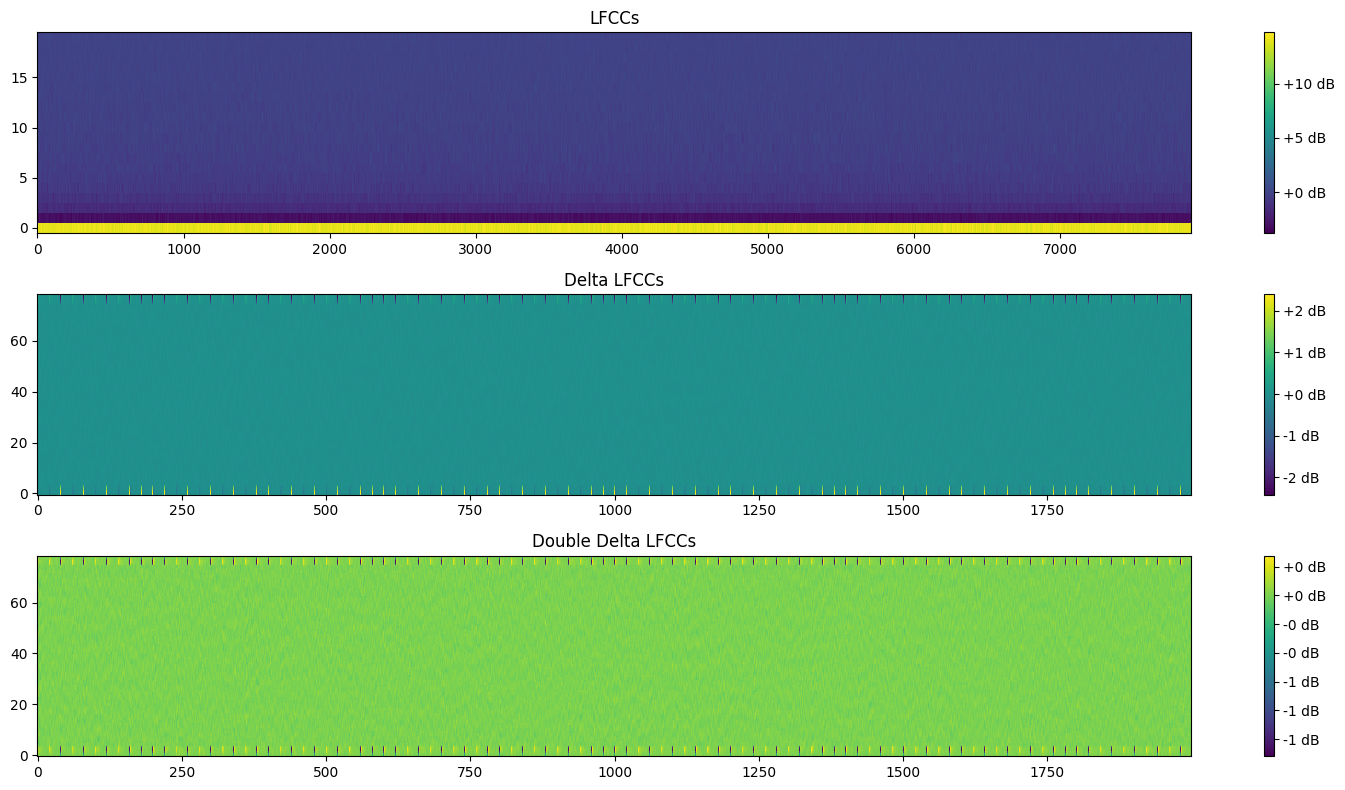

In [128]:
LFCCs_combined = np.concatenate(all_stat, axis=1)  
Delta_LFCCs_combined = np.concatenate(all_delta, axis=1)
Double_Delta_LFCCs_combined = np.concatenate(all_double_delta, axis=1)

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.imshow(LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.imshow(Delta_LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.imshow(Double_Delta_LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

Processed sample 1/1: LFCC shape (500, 3)
Shape of MFCCs: (3, 500)
LFCCs: [[[-9.64149395e+01 -1.23141491e+02 -1.26811941e+02]
  [ 7.87199081e+00  2.02541665e+01  2.16830981e+01]
  [ 7.00307280e+00  1.15545205e+01  1.22272516e+01]
  ...
  [ 1.28830122e-02  1.28795258e-02  1.28716380e-02]
  [ 8.59761242e-03  8.59524146e-03  8.58989450e-03]
  [ 4.37783958e-03  4.37664035e-03  4.37393940e-03]]]
Shape of LFCCs: (1, 500, 3)
Combined Features:
[[-1.15091507e+02  1.93681481e+01  1.00102306e+01 ... -9.64149395e+01
  -1.23141491e+02 -1.26811941e+02]
 [-1.30156926e+02  3.34879631e+01  6.82299475e+00 ...  7.87199081e+00
   2.02541665e+01  2.16830981e+01]
 [-1.32377946e+02  3.53494150e+01  6.64006284e+00 ...  7.00307280e+00
   1.15545205e+01  1.22272516e+01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.28830122e-02
   1.28795258e-02  1.28716380e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.59761242e-03
   8.59524146e-03  8.58989450e-03]
 [ 0.00000000e+00  0.00000000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-126.81194140928132..21.683098084744827].


Combined Features:
[[-1.15091507e+02  1.93681481e+01  1.00102306e+01 ... -9.64149395e+01
  -1.23141491e+02 -1.26811941e+02]
 [-1.30156926e+02  3.34879631e+01  6.82299475e+00 ...  7.87199081e+00
   2.02541665e+01  2.16830981e+01]
 [-1.32377946e+02  3.53494150e+01  6.64006284e+00 ...  7.00307280e+00
   1.15545205e+01  1.22272516e+01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.28830122e-02
   1.28795258e-02  1.28716380e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.59761242e-03
   8.59524146e-03  8.58989450e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.37783958e-03
   4.37664035e-03  4.37393940e-03]]
Shape of Combined Features: (500, 503)


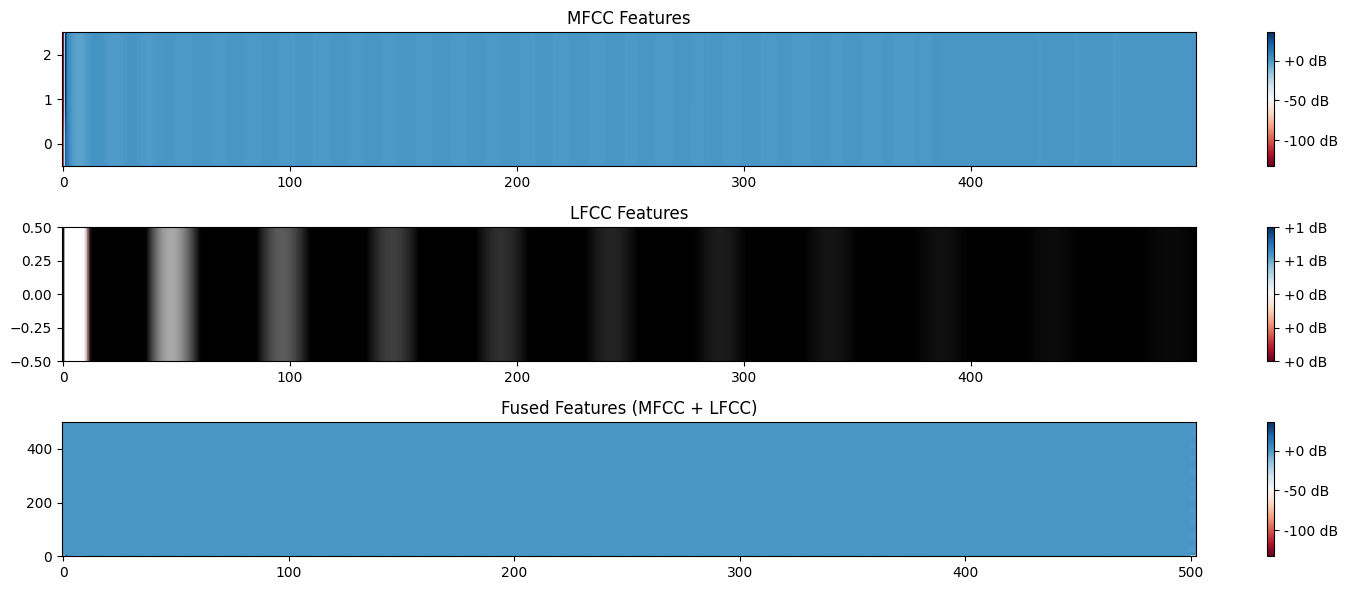

Combined features saved to combined_features_1728981750.csv


In [129]:
sr = 22050  
t = np.linspace(0, 5, 5 * sr, endpoint=False)  # 5 seconds
frequency = 440 
signal = 0.5 * np.sin(2 * np.pi * frequency * t)

Window_Length = 2048  
NFFT = 2048  
No_Filter = 500

def fuse_features(mfccs, lfccs):
    mfccs = np.array(mfccs)
    lfccs = np.array(lfccs)

    if mfccs.ndim == 3 and mfccs.shape[0] == 1:
        mfccs = np.squeeze(mfccs, axis=0)  # Remove single extra dimension
    if lfccs.ndim == 3 and lfccs.shape[0] == 1:
        lfccs = np.squeeze(lfccs, axis=0) 
    
    if mfccs.ndim != 2 or lfccs.ndim != 2:
        print("Both MFCC and LFCC must be 2D arrays for fusion.")
        return None, None

    if mfccs.size == 0 or lfccs.size == 0:
        print("One of the features is empty. Cannot fuse.")
        return None, None
    
    mfcc_frames = mfccs.shape[0]
    lfcc_frames = lfccs.shape[0]

    # If MFCCs have fewer frames, pad them
    if mfcc_frames < lfcc_frames:
        padding = np.zeros((lfcc_frames - mfcc_frames, mfccs.shape[1]))  # Assuming same feature dimension
        mfccs = np.vstack([mfccs, padding])  # Stack vertically to pad MFCCs

    # If LFCCs have fewer frames, pad them
    elif lfcc_frames < mfcc_frames:
        padding = np.zeros((mfcc_frames - lfcc_frames, lfccs.shape[1]))  # Assuming same feature dimension
        lfccs = np.vstack([lfccs, padding]) 

    combined_features = np.concatenate((mfccs, lfccs), axis=-1)

    print("Combined Features:")
    print(combined_features)
    print("Shape of Combined Features:", combined_features.shape)
    print("MFCCs shape:", mfccs.shape)
    print("LFCCs shape:", lfccs.shape)

    csv_file_path = f'combined_features_{int(time.time())}.csv' 
    combined_df = pd.DataFrame(combined_features.T)  
    combined_df.to_csv(csv_file_path, index=False)
    
    return combined_features, csv_file_path
    

def plot_features(mfccs, lfccs, fused_features):
    """Plot MFCC, LFCC, and fused features using matplotlib."""
    plt.figure(figsize=(15, 6))

    plt.subplot(3, 1, 1)
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('MFCC Features')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 1, 2)
    plt.imshow(lfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('LFCC Features')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 1, 3)
    plt.imshow(fused_features, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('Fused Features (MFCC + LFCC)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

mfccs, _, _ = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)

lfccs, _, _ = extract_lfcc([signal], sr, Window_Length, NFFT, No_Filter)

print("Shape of MFCCs:", mfccs.shape)

if isinstance(lfccs, list):
    lfccs = np.array(lfccs)  

print("LFCCs:", lfccs)
print("Shape of LFCCs:", lfccs.shape)

# Check if either is empty
if mfccs.size == 0:
    print("MFCCs are empty after extraction.")

if lfccs.size == 0:
    print("LFCCs are empty after extraction.")


fused_features, csv_file_path = fuse_features(mfccs, lfccs)

if mfccs.size > 0 and lfccs.size > 0:
    fused_features, csv_file_path = fuse_features(mfccs, lfccs)

if fused_features is not None:
    print("Combined Features:")
    print(fused_features)
    print("Shape of Combined Features:", fused_features.shape)

    plot_features(mfccs, lfccs, fused_features)

    print(f"Combined features saved to {csv_file_path}")